# Running SCENIC+

This tutorial will illustrate how to run the SCENIC+ pipeline via Snakemake based on https://scenicplus.readthedocs.io/en/latest/human_cerebellum.html

Before running this pipeline you should:

- Preprocess the scATAC-seq side of the data using [pycisTopic](https://github.com/aertslab/pycisTopic), [click here](...) for a tutorial.
- Preprocess the scRNA-seq side of the data using [Scanpy](https://github.com/scverse/scanpy), [click here](...) for a tutorial.
- Optionally, but highly recommended, generate a cisTarget database using the consensus peaks specific to your dataset, [click here](...) for a tutorial.

In case you have human, mouse or fly data you can also use one of the precomputed cisTarget databases. These can be found on our [resources website](https://resources.aertslab.org/cistarget/databases/).

In [1]:
from typing import Optional, List
from arboreto import core as arboreto_core

import pycisTopic
import scenicplus
scenicplus.__version__
import pandas as pd
import scanpy as sc
import sys
import os
import requests
import pycisTopic
#supress warnings
import warnings  
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import pyranges as pr
import requests
import pandas as pd
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
import numpy as np
from pycisTopic.qc import compute_qc_stats
from pycisTopic.iterative_peak_calling import *
import scanpy as sc
from pycisTopic.pseudobulk_peak_calling import peak_calling
_stderr = sys.stderr
null = open(os.devnull,'wb')
import pybiomart as pbm

In [2]:
!scenicplus
#os.chdir("/Users/parham/pbmc_new")
path="/Users/parham/pbmc_tutorial"
os.chdir(path)



   ____   ____ _____ _   _ ___ ____      
  / ___| / ___| ____| \ | |_ _/ ___| _ 
  \___ \| |   |  _| |  \| || | |   _|.|_
   ___) | |___| |___| |\  || | |__|_..._|
  |____/ \____|_____|_| \_|___\____||_| 


scenicplus verions: 1.0a1
usage: scenicplus [-h] {init_snakemake,prepare_data,grn_inference} ...

Single-Cell Enhancer-driven gene regulatory Network Inference and Clustering

positional arguments:
  {init_snakemake,prepare_data,grn_inference}

options:
  -h, --help            show this help message and exit


Below we will use the Snakemake pipeline, which is already included in SCENIC+ to perform the analysis.

In [3]:
import os
#work_dir = '/Users/parham/pbmc_new'
#tmp_dir = '/Users/parham/pbmc_new/scratch/'
tmp_dir = '/Users/parham/tmp/'
out_dir = "/Users/parham/pbmc_tutorial/outs"
adata = sc.read_h5ad(os.path.join(out_dir, 'scRNA/adata.h5ad'))
# adata.obs.index = adata.obs.index + '-10x_pbmc'
adata.obs

,n_genes,doublet_score,predicted_doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,ingest_celltype_label,leiden_res_0.8,celltype,sample_id
AAACAGCCAAATATCC-1-10x_pbmc,2272,0.007582,False,2271,4746.0,369.0,7.774969,NK cells,8,NK_cells,10x_pbmc
AAACAGCCAGGAACTG-1-10x_pbmc,3254,0.022142,False,3253,7760.0,693.0,8.930412,CD14+ Monocytes,1,CD14+_Monocytes,10x_pbmc
AAACAGCCAGGCTTCG-1-10x_pbmc,1798,0.037975,False,1793,3661.0,409.0,11.171811,CD14+ Monocytes,3,CD14+_Monocytes,10x_pbmc
AAACCAACACCTGCTC-1-10x_pbmc,1145,0.023256,False,1142,2159.0,271.0,12.552108,B cells,6,B_cells,10x_pbmc
AAACCAACAGATTCAT-1-10x_pbmc,1495,0.013229,False,1494,2909.0,293.0,10.072189,NK cells,5,CD8_T_cells,10x_pbmc
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGGCATCCGTAA-1-10x_pbmc,1346,0.007582,False,1343,2560.0,432.0,16.875000,B cells,6,B_cells,10x_pbmc
TTTGTGGCATTAGCCA-1-10x_pbmc,972,0.024421,False,969,1746.0,191.0,10.939290,CD4 T cells,0,CD4_T_cells,10x_pbmc
TTTGTGGCATTGCGAC-1-10x_pbmc,2330,0.005080,False,2330,4772.0,316.0,6.621961,NK cells,8,NK_cells,10x_pbmc
TTTGTGTTCCGCCTAT-1-10x_pbmc,1057,0.061224,False,1056,1913.0,252.0,13.173027,CD4 T cells,0,CD4_T_cells,10x_pbmc


## Initialize Snakemake

To run Snakemake we first have to initialize the pipeline. This will create a folder named `Snakemake` containing a folder for the `config.yaml` file and a folder containing the actual workflow definition.

In [4]:
!mkdir -p scplus_pipeline
!scenicplus init_snakemake --out_dir scplus_pipeline

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-06-16 17:20:26,006 SCENIC+      INFO     Creating snakemake folder in: scplus_pipeline


### scRNA-seq preparation

scRNA-seq side of the experiment can be processed according to the regular [Scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) tutorial. Just make sure to store the raw gene expresison matrix in `adata.raw`.

**Call the following piece of code:**

```python

adata.raw = adata

```

**_BEFORE_** normalizing the data

```python

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

```

In [5]:
ls data


fragments.tsv.gz       pbmc3k_processed.h5ad
fragments.tsv.gz.tbi   pbmc_matrix.h5


Next, modify the `config.yaml` file.

The most important fields are `input_data` and `output_data`. For the other default values can be kept:

**input_data**:
This is the input to the pipeline, these files should already exist.

- `cisTopic_obj_fname`: the path to your cistopic object containing processed chromatin accessibility data.
- `GEX_anndata_fname`: the path to your scanpy h5ad file containing processed gene expression data.
- `region_set_folder`: the path to directory containing several directories with bed files. Differential motif enrichment (1 vs all) will be run within each sub folder. As an example the structure of the folder is shown below.
- `ctx_db_fname`: the path to the cisTarget **ranking** database.
- `dem_db_fname`: the path to the cisTarget **score** database.
- `path_to_motif_annotations`: the path to the motif-to-TF annotaiton. For human (hgnc), mouse (mgi), chicken and fly (flybase) these files can be downloaded from [our resources website](https://resources.aertslab.org/cistarget/motif2tf/), please download the relevant file starting with "motifs-v10nr_clust".

**output_data**:
This is the output of the pipeline, these files will be created.
If some of these files already exists (for example when the pipeline has only been partially run) some steps of the workflow might be skipped.

- `combined_GEX_ACC_mudata`: where the [MuData](https://github.com/scverse/mudata) object containing gene expression and imputed chromatin accessibility should be stored.
- `dem_result_fname`: where the h5 file containing DEM based enriched motifs should be stored.
- `ctx_result_fname`: where the h5 file containing cistarget based enriched motifs should be stored.
- `output_fname_dem_html`: where the html file containing DEM based enriched motifs should be stored.
- `output_fname_ctx_html`: where the html file containing cistarget based enriched motifs should be stored.
- `cistromes_direct`: where the [AnnData](https://github.com/scverse/anndata) h5ad file should be stored containing TF-to-region links based on direct motif-to-TF annotations.
- `cistromes_extended`: where the [AnnData](https://github.com/scverse/anndata) h5ad file should be stored containing TF-to-region links based on exteded (e.g. orthology based) motif-to-TF annotations.
- `tf_names`: where a text file containing TF names, based on the enriched motifs, should be stored.
- `genome_annotation`: where a data frame (tsv) should be stored containing genome annotation.
- `chromsizes`: where the chromsizes file should be stored.
- `search_space`: where the search space for each gene should be stored.
- `tf_to_gene_adjacencies`: where the TF-to-gene links, with importance scores, should be stored.
- `region_to_gene_adjacencies`: where the region-to-gene links, with importance scores, should be stored.
- `eRegulons_direct`: where the dataframe (tsv) containing eRegulons (TF-region-gene links) based on direct motif-to-TF annotations should be stored.
- `eRegulons_extended`: where the dataframe (tsv) containing eRegulons (TF-region-gene links) based on extended (e.g. orthology based) motif-to-TF annotations should be stored.
- `AUCell_direct`: where the [MuData](https://github.com/scverse/mudata) containing target gene and target region enrichement scores for each cells, based on direct motif-to-TF annotations should be stored.
- `AUCell_extended`: where the [MuData](https://github.com/scverse/mudata) containing target gene and target region enrichement scores for each cells, based on extended (e.g. orthology based) motif-to-TF annotations should be stored.
- `scplus_mdata`: where the final output [MuData](https://github.com/scverse/mudata) containing AUCell values and the (TF-region-gene links) based on both direct and extended motif-to-TF annotations should be stored.

**params_general**
General parameters.
- `temp_dir`: Directory to store temporary data.
- `n_cpu`: maximum number of CPU's to use.
- `seed`: seed to use to initialize the random state.

**params_data_preparation**
Parameters used for the data preparation step.
- `bc_transform_func`: lambda function to transform the scRNA-seq barcode so they match with the scATAC-seq ones
- `is_multiome`: boolean specifying wether the data is multiome or not.
- `key_to_group_by`: in case of non-multiome data, cell metadata variable to group cells by in order to generate metacells that can be matched across the scRNA-seq and scATAC-seq side of the data. This variable should be prefixed with eiter "GEX:" or "ACC:".
- `nr_cells_per_metacells`: in case of non-multione data, number of cells to sample to sample for each metacell.
- `direct_annotation`: Which annotations fields to use for generating direct motif-to-TF annotations.
- `extended_annotation`: Which annotations fields to use for generating extended motif-to-TF annotations
- `species`: Species name, for example "hsapiens"
- `biomart_host`: Biomart host to use for downloading genome annotations. Make sure that this host matches the genome reference you are using, please visit [this website](https://www.ensembl.org/info/website/archives/index.html) for more information.
- `search_space_upstream`: string in the form "\<minmal\> \<maximal\>" specifying the \<minimal\> and \<maximal\> search space to consider downstream of the TSS of each gene.
- `search_space_downstream`: string in the form "\<minmal\> \<maximal\>" specifying the \<minimal\> and \<maximal\> search space to consider upstrean of the TSS of each gene.
- `search_space_extend_tss`: string in the form "\<upstream\> \<downstream\>" specifying the amount of basepairs the TSS of each gene should be extended, \<upstream\>  and 

**params_motif_enrichment**
parameters for performing motif enrichment analysis.
- `species`: Species used for the analysis. This parameter is used to download the correct motif-to-TF annotations from the cisTarget webservers.
- `annotation_version`: Version of the motif-to-TF annotation to use. This parameter is used to download the correct motif-to-TF data from the cisTarget webservers.
- `motif_similarity_fdr`: Threshold on motif similarity scores for calling similar motifs.
- `orthologous_identity_threshold`: Threshold on the protein-protein orthology score for calling orthologous motifs
- `annotations_to_use`: Which annotations to use for annotation motifs to TFs.
- `fraction_overlap_w_dem_database`: Fraction of nucleotides, of regions in the bed file, that should overlap with regions in the scores database.
- `dem_max_bg_regions`: Maximum number of regions to use as background for DEM.
- `dem_balance_number_of_promoters`: Boolean specifying wether the number of promoters should be equalized between the foreground and background set of regions.
- `dem_promoter_space`: Number of basepairs up- and downstream of the TSS that are considered as being the promoter for that gene.
- `dem_adj_pval_thr`: Threshold on the Benjamini-Hochberg adjusted p-value from the Wilcoxon test performed on the motif score of foreground vs background regions for a motif to be considered as enriched.
- `dem_log2fc_thr`: Threshold on the log2 fold change of the motif score of foreground vs background regions for a motif to be considered as enriched.
- `dem_mean_fg_thr`: Minimul mean signal in the foreground to consider a motif enriched for DEM.
- `dem_motif_hit_thr`: Minimal CRM score to consider a region enriched for a motif for DEM.
- `fraction_overlap_w_ctx_database`: Fraction of nucleotides, of regions in the bed file, that should overlap with regions in the ranking database.
- `ctx_auc_threshold`: Threshold on the AUC value for calling significant motifs
- `ctx_nes_threshold`: Threshold on the NES value for calling significant motifs.
- `ctx_rank_threshold`: The total number of ranked regions to take into account when creating a recovery curves.

**params_inference**
Parameters for performing GRN inference.
- `tf_to_gene_importance_method`: Method to use to calculate TF-to-gene importance scores.
- `region_to_gene_importance_method`: Method to use to calculate region-to-gene importance scores.
- `region_to_gene_correlation_method`: Method to use to calculate region-to-gene correlation coefficients.
- `order_regions_to_genes_by`: Value to order region-to-gene scores by for selecting top regions per gene
- `order_TFs_to_genes_by`: value to order TF-to-gene scores by for selecting top TFs per gene
- `gsea_n_perm`: Number or permutations to perform for calculating GSEA enrichment scores.
- `quantile_thresholds_region_to_gene`: space seperated list containing quantile threshold to be used for binarizing region-to-gene links.
- `top_n_regionTogenes_per_gene`: space seperated list containing the number of top regions per gene for binarizing region-to-gene links.
- `top_n_regionTogenes_per_region`: space seperated list containging per region the number of top genes for binarizing region-to-gene links
- `min_regions_per_gene`: minimum number of regions per gene for the link to be included in eGRNs.
- `rho_threshold`: absolute threshold on the correlation coefficient to seperate positive and negative region-to-gene and TF-to-gene links
- `min_target_genes`: minimum number of target genes per TF for the link(s) to be includedin eGRNs.


In [6]:
!/usr/local/bin/tree /Users/parham/pbmc_new/outs/region_sets


/Users/parham/pbmc_new/outs/region_sets
├── DARs_cell_type
│   ├── CD14m.bed
│   ├── CD16m.bed
│   ├── CD4m.bed
│   ├── CD4n.bed
│   ├── CD8a.bed
│   ├── CD8n.bed
│   ├── Imono.bed
│   ├── MAIT.bed
│   ├── NK.bed
│   ├── mB.bed
│   ├── mDC.bed
│   ├── nB.bed
│   └── pDC.bed
├── Topics_otsu
│   ├── Topic1.bed
│   ├── Topic10.bed
│   ├── Topic11.bed
│   ├── Topic12.bed
│   ├── Topic13.bed
│   ├── Topic14.bed
│   ├── Topic15.bed
│   ├── Topic16.bed
│   ├── Topic2.bed
│   ├── Topic3.bed
│   ├── Topic4.bed
│   ├── Topic5.bed
│   ├── Topic6.bed
│   ├── Topic7.bed
│   ├── Topic8.bed
│   └── Topic9.bed
└── Topics_top_3k
    ├── Topic1.bed
    ├── Topic10.bed
    ├── Topic11.bed
    ├── Topic12.bed
    ├── Topic13.bed
    ├── Topic14.bed
    ├── Topic15.bed
    ├── Topic16.bed
    ├── Topic2.bed
    ├── Topic3.bed
    ├── Topic4.bed
    ├── Topic5.bed
    ├── Topic6.bed
    ├── Topic7.bed
    ├── Topic8.bed
    └── Topic9.bed

4 directories, 45 files


In [7]:
out_dir

'/Users/parham/pbmc_tutorial/outs'

In [8]:
import yaml
# Read the YAML file
with open('scplus_pipeline/Snakemake/config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Modify the configuration as needed
config['input_data']['cisTopic_obj_fname'] = os.path.join(out_dir, "cistopic_obj.pkl")
config['input_data']['GEX_anndata_fname'] =  os.path.join(out_dir, 'scRNA/adata.h5ad')
config['input_data']['region_set_folder'] = os.path.join(out_dir, "region_sets")
config['input_data']['ctx_db_fname'] = '/Users/parham/Downloads/hg38_screen_v10_clust.regions_vs_motifs.rankings.feather'
config['input_data']['dem_db_fname'] = '/Users/parham/Downloads/hg38_screen_v10_clust.regions_vs_motifs.scores.feather'
config['input_data']['path_to_motif_annotations'] = '/Users/parham/Downloads/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl'
config['params_general']['temp_dir'] = tmp_dir
config['params_general']['n_cpu'] = 10

# Update the paths for the output files
config['output_data']['combined_GEX_ACC_mudata'] = out_dir + "/ACC_GEX.h5mu"
config['output_data']['dem_result_fname'] = out_dir + "/dem_results.hdf5"
config['output_data']['ctx_result_fname'] = out_dir + "/ctx_results.hdf5"
config['output_data']['output_fname_dem_html'] = out_dir + "/dem_results.html"
config['output_data']['output_fname_ctx_html'] = out_dir + "/ctx_results.html"
config['output_data']['cistromes_direct'] = out_dir + "/cistromes_direct.h5ad"
config['output_data']['cistromes_extended'] = out_dir + "/cistromes_extended.h5ad"
config['output_data']['tf_names'] = out_dir + "/tf_names.txt"
config['output_data']['genome_annotation'] = out_dir + "/genome_annotation.tsv"
config['output_data']['chromsizes'] = out_dir + "/chromsizes.tsv"
config['output_data']['search_space'] = out_dir + "/search_space.tsv"
config['output_data']['tf_to_gene_adjacencies'] = out_dir + "/tf_to_gene_adj.tsv"
config['output_data']['region_to_gene_adjacencies'] = out_dir + "/region_to_gene_adj.tsv"
config['output_data']['eRegulons_direct'] = out_dir + "/eRegulon_direct.tsv"
config['output_data']['eRegulons_extended'] = out_dir + "/eRegulons_extended.tsv"
config['output_data']['AUCell_direct'] = out_dir + "/AUCell_direct.h5mu"
config['output_data']['AUCell_extended'] = out_dir + "/AUCell_extended.h5mu"
config['output_data']['scplus_mdata'] = out_dir + "/scplusmdata.h5mu"



# Write the modified configuration back to the YAML file
with open('scplus_pipeline/Snakemake/config/config.yaml', 'w') as file:
    yaml.safe_dump(config, file)

In [9]:
!/usr/local/bin/bat scplus_pipeline/Snakemake/config/config.yaml


───────┬────────────────────────────────────────────────────────────────────────
       │ File: scplus_pipeline/Snakemake/config/config.yaml
───────┼────────────────────────────────────────────────────────────────────────
   1   │ input_data:
   2   │   GEX_anndata_fname: /Users/parham/pbmc_tutorial/outs/scRNA/adata.h5ad
   3   │   cisTopic_obj_fname: /Users/parham/pbmc_tutorial/outs/cistopic_obj.pkl
   4   │   ctx_db_fname: /Users/parham/Downloads/hg38_screen_v10_clust.regions_v
       │ s_motifs.rankings.feather
   5   │   dem_db_fname: /Users/parham/Downloads/hg38_screen_v10_clust.regions_v
       │ s_motifs.scores.feather
   6   │   path_to_motif_annotations: /Users/parham/Downloads/motifs-v10nr_clust
       │ -nr.hgnc-m0.001-o0.0.tbl
   7   │   region_set_folder: /Users/parham/pbmc_tutorial/outs/region_sets
   8   │ output_data:
   9   │   AUCell_direct: /Users/parham/pbmc_tutorial/outs/AUCell_direct.h5mu
  10   │   AUCell_extended: /Users/parham/pbmc_tutorial/outs/AUCell_extended

## Run pipeline

Once the config file is filled in the pipeline can be run.

In [10]:
cd scplus_pipeline/Snakemake

/Users/parham/pbmc_tutorial/scplus_pipeline/Snakemake


In [11]:
ls


config/   workflow/


In [12]:
out_dir

'/Users/parham/pbmc_tutorial/outs'

In [13]:
import pickle

cistopic_obj = pickle.load(open(os.path.join(out_dir, 'cistopic_obj.pkl'), 'rb'))
#cistopic_obj.cell_names 

In [14]:
common_barcodes = set(cistopic_obj.cell_names ).intersection(set(adata.obs_names))
len(common_barcodes)


2463

In [16]:
!snakemake --cores 10

Assuming unrestricted shared filesystem usage for local execution.
Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 10
Rules claiming more threads will be scaled down.
Job stats:
job                            count
---------------------------  -------
AUCell_direct                      1
AUCell_extended                    1
all                                1
download_genome_annotations        1
eGRN_direct                        1
eGRN_extended                      1
get_search_space                   1
motif_enrichment_cistarget         1
motif_enrichment_dem               1
prepare_GEX_ACC_multiome           1
prepare_menr                       1
region_to_gene                     1
scplus_mudata                      1
tf_to_gene                         1
total                             14

Select jobs to execute...
Execute 1 jobs...

[Sun Jun 16 17:21:13 2024]
localrule motif_enrichment_cistarget:
    input: /Users/parham/pbmc_tutorial/outs/region_sets, /Users/par

## Main outputs

The main output of the pipeline is the `scplusmdata.h5mu` file. This is a MuData file containing the eRegulons and enrichment scores.

In [19]:
import os
os.chdir(path)

import mudata
scplus_mdata = mudata.read("outs/scplusmdata.h5mu")

Direct and extended predicted TF-to-region-to-gene links. This dataframe contains also a ranking of each TF-region-gene triplet, based on its importance `triplet_rank`.

In [20]:
scplus_mdata.uns["direct_e_regulon_metadata"]


,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr12:109845253-109845753,TCHP,0.034961,0.052163,0.001824,0.001824,ARID3A,False,ARID3A_direct_+/+,ARID3A_direct_+/+_(47g),ARID3A_direct_+/+_(53r),1.023877,1,0.088441,41372
1,chr12:131092730-131093230,ADGRD1,0.039673,0.135904,0.005392,0.005392,ARID3A,False,ARID3A_direct_+/+,ARID3A_direct_+/+_(47g),ARID3A_direct_+/+_(53r),0.823127,1,0.082222,38638
2,chr20:4720529-4721029,SLC23A2,0.061733,0.114734,0.007083,0.007083,ARID3A,False,ARID3A_direct_+/+,ARID3A_direct_+/+_(47g),ARID3A_direct_+/+_(53r),0.742879,1,0.095474,40807
3,chr1:46527958-46528458,FAAH,0.145681,0.089034,0.012970,0.012970,ARID3A,False,ARID3A_direct_+/+,ARID3A_direct_+/+_(47g),ARID3A_direct_+/+_(53r),1.998023,1,0.087992,966
4,chr1:109263520-109264020,MYBPHL,0.057709,0.054864,0.003166,0.003166,ARID3A,False,ARID3A_direct_+/+,ARID3A_direct_+/+_(47g),ARID3A_direct_+/+_(53r),1.100565,1,0.056118,20148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67382,chr1:58783944-58784444,JUN,0.035554,-0.079806,-0.002837,0.002837,YBX1,False,YBX1_direct_-/-,YBX1_direct_-/-_(14g),YBX1_direct_-/-_(18r),0.127648,-1,-0.064522,49558
67383,chr7:151227057-151227557,SMARCD3,0.015559,-0.188005,-0.002925,0.002925,YBX1,False,YBX1_direct_-/-,YBX1_direct_-/-_(14g),YBX1_direct_-/-_(18r),0.188727,-1,-0.057970,65721
67384,chr1:151347109-151347609,PIP5K1A,0.067901,-0.120858,-0.008206,0.008206,YBX1,False,YBX1_direct_-/-,YBX1_direct_-/-_(14g),YBX1_direct_-/-_(18r),0.193219,-1,-0.050499,40932
67385,chr15:64825547-64826047,ZNF609,0.032976,-0.152797,-0.005039,0.005039,YBX1,False,YBX1_direct_-/-,YBX1_direct_-/-_(14g),YBX1_direct_-/-_(18r),0.165163,-1,-0.051979,51823


In [21]:
scplus_mdata.uns["extended_e_regulon_metadata"]


,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr4:55358657-55359157,TMEM165,0.082718,0.402098,0.033261,0.033261,ATF3,True,ATF3_extended_+/+,ATF3_extended_+/+_(638g),ATF3_extended_+/+_(1121r),0.679916,1,0.232132,22283
1,chr3:173395140-173395640,NLGN1,0.083773,0.055429,0.004643,0.004643,ATF3,True,ATF3_extended_+/+,ATF3_extended_+/+_(638g),ATF3_extended_+/+_(1121r),0.793502,1,0.052777,19209
2,chr1:206456956-206457456,SRGAP2,0.040840,0.579159,0.023653,0.023653,ATF3,True,ATF3_extended_+/+,ATF3_extended_+/+_(638g),ATF3_extended_+/+_(1121r),1.506924,1,0.366154,30643
3,chr12:10186278-10186778,OLR1,0.043093,0.201876,0.008699,0.008699,ATF3,True,ATF3_extended_+/+,ATF3_extended_+/+_(638g),ATF3_extended_+/+_(1121r),0.928922,1,0.195316,42342
4,chr13:28401584-28402084,FLT1,0.041585,0.105364,0.004382,0.004382,ATF3,True,ATF3_extended_+/+,ATF3_extended_+/+_(638g),ATF3_extended_+/+_(1121r),0.565082,1,0.068300,39105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46893,chr14:67623119-67623619,VTI1B,0.012737,-0.093029,-0.001185,0.001185,TCF7,True,TCF7_extended_-/-,TCF7_extended_-/-_(83g),TCF7_extended_-/-_(79r),0.262728,-1,-0.065769,30915
46894,chr5:150458778-150459278,CD74,0.019839,-0.628634,-0.012472,0.012472,TCF7,True,TCF7_extended_-/-,TCF7_extended_-/-_(83g),TCF7_extended_-/-_(79r),3.115024,-1,-0.520282,3664
46895,chr20:50146842-50147342,CEBPB,0.001338,-0.178768,-0.000239,0.000239,TCF7,True,TCF7_extended_-/-,TCF7_extended_-/-_(83g),TCF7_extended_-/-_(79r),0.591110,-1,-0.279861,46792
46896,chr16:87489975-87490475,MAP1LC3B,0.034775,-0.130625,-0.004542,0.004542,TCF7,True,TCF7_extended_-/-,TCF7_extended_-/-_(83g),TCF7_extended_-/-_(79r),0.382676,-1,-0.084119,40955


In [ ]:
## Downstream analysis

In [ ]:
## eRegulon dimensionality reduction

The eRegulon enrichment scores can be used to perform dimensionality reductions

In [22]:
import scanpy as sc
import anndata
eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"]],
    axis = 1,
)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/parham/anaconda3/envs/plus/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


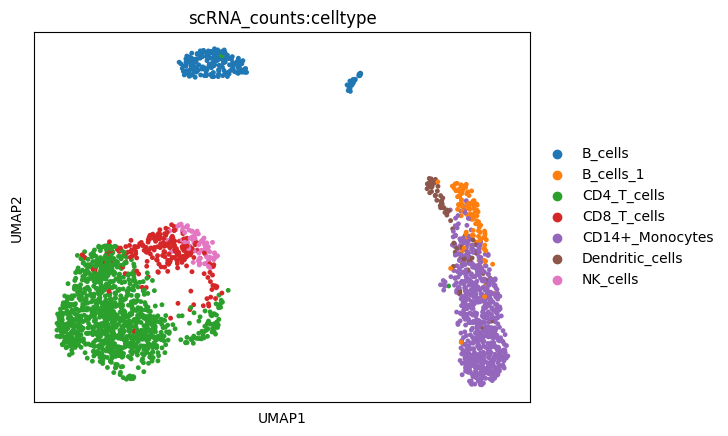

In [23]:
eRegulon_gene_AUC.obs = scplus_mdata.obs.loc[eRegulon_gene_AUC.obs_names]
sc.pp.neighbors(eRegulon_gene_AUC, use_rep = "X")
sc.tl.umap(eRegulon_gene_AUC)
sc.pl.umap(eRegulon_gene_AUC, color = "scRNA_counts:celltype")

# Converting mudata output to old-style SCENIC+ object.

Not all functions in the original release of SCENIC+ are updated to use the new mudata output of SCENIC+. To be able to still use these old functions while they get updated we have a function to convert the mudata object the the old SCENIC+ object.

In [24]:
import sys
sys.path.append('/Users/parham/anaconda3/envs/plus/lib/python3.11/site-packages/scenicplus/')
from scenicplus_class import mudata_to_scenicplus


In [25]:
scplus_obj = mudata_to_scenicplus(
    mdata = scplus_mdata,
    path_to_cistarget_h5 = "outs/ctx_results.hdf5",
    path_to_dem_h5 = "outs/dem_results.hdf5"
)

In [58]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 2463 x 21255 and n_cells x n_regions = 2463 x 192341
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
	metadata_cell:'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'ingest_celltype_label', 'leiden_res_0.8', 'celltype', 'sample_id'
	menr:'cistarget_DARs_cell_type_B_cells', 'cistarget_DARs_cell_type_B_cells_1', 'cistarget_DARs_cell_type_CD14+_Monocytes', 'cistarget_DARs_cell_type_CD4_T_cells', 'cistarget_DARs_cell_type_CD8_T_cells', 'cistarget_DARs_cell_type_Dendritic_cells', 'cistarget_DARs_cell_type_NK_cells', 'cistarget_Topics_otsu_Topic1', 'cistarget_Topics_otsu_Topic10', 'cistarget_Topics_otsu_Topic11', 'cistarget_Topics_otsu_Topic12

In [27]:
import sys
sys.path.append('/Users/parham/anaconda3/envs/plus/lib/python3.11/site-packages/scenicplus/')
from scenicplus_mudata import ScenicPlusMuData


## eRegulon specificity score

In [42]:
sys.path.append('/Users/parham/anaconda3/envs/plus/lib/python3.11/site-packages/scenicplus/')

from scenicplus.RSS import *


In [43]:
regulon_specificity_scores

<function scenicplus.RSS.regulon_specificity_scores(scplus_obj: scenicplus.scenicplus_class.SCENICPLUS, variable: str, auc_key: Optional[str] = 'eRegulon_AUC', signature_keys: Optional[List[str]] = ['Gene_based', 'Region_based'], selected_regulons: Optional[List[int]] = None, scale: Optional[bool] = False, out_key_suffix: Optional[str] = '')>

In [30]:
regulon_specificity_scores

<function scenicplus.RSS.regulon_specificity_scores(scplus_obj: scenicplus.scenicplus_class.SCENICPLUS, variable: str, auc_key: Optional[str] = 'eRegulon_AUC', signature_keys: Optional[List[str]] = ['Gene_based', 'Region_based'], selected_regulons: Optional[List[int]] = None, scale: Optional[bool] = False, out_key_suffix: Optional[str] = '')>

In [34]:


rss = regulon_specificity_scores(
    scplus_mudata = scplus_mdata,
    variable = "scRNA_counts:celltype",
    modalities = ["direct_gene_based_AUC", "extended_gene_based_AUC"]
)
plot_rss(
    data_matrix = rss,
    top_n = 3,
    num_columns = 5
)

TypeError: regulon_specificity_scores() got an unexpected keyword argument 'scplus_mudata'

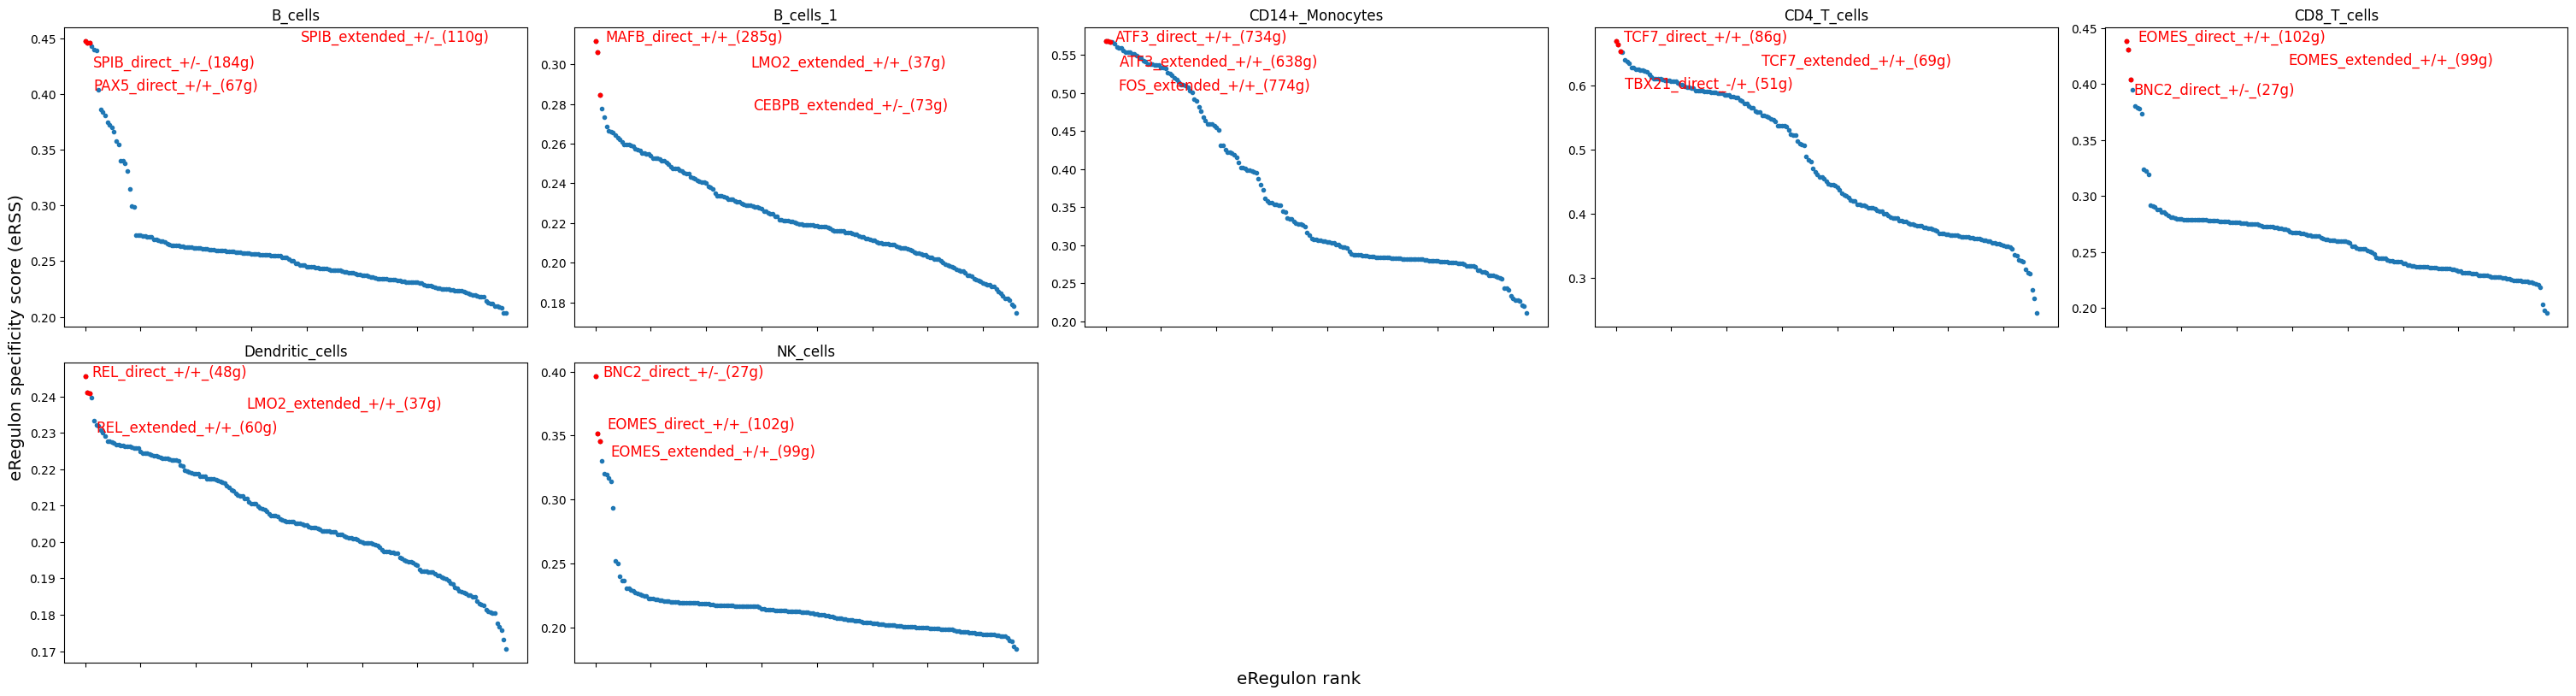

In [44]:
from typing import List, Tuple, Union

from mudata import MuData
def plot_rss(data_matrix: pd.DataFrame,
             top_n: int = 5,
             selected_groups: List[str] = None,
             num_columns: int = 1,
             figsize: Tuple[float, float] = (6, 4),
             fontsize: int = 12,
             save: str = None):
    """
    Plot RSS values per group

    Parameters
    ---------
    data_matrix: `class::pd.DataFrame`
        A pandas dataframe with RSS scores per variable.
    top_n: int, optional
        Number of top eRegulons to highlight.
    selected_groups: List, optional
        Groups to plot. Default: None (all)
    num_columns: int, optional
        Number of columns for multiplotting
    figsize: tuple, optional
        Size of the figure. If num_columns is 1, this is the size for each figure;
        if num_columns is above 1, this is the overall size of the figure (if keeping
        default, it will be the size of each subplot in the figure). Default: (6.4, 4.8)
    fontsize: int, optional
        Size of the eRegulons names in plot.
    save: str, optional
        Path to save plot. Default: None.
    """

    if selected_groups is None:
        cats = sorted(data_matrix.index.tolist())
    else:
        cats = selected_groups

    if num_columns > 1:
        num_rows = int(np.ceil(len(cats) / num_columns))
        figsize = (figsize[0] * num_columns, figsize[1] * num_rows)
        i = 1
        fig = plt.figure(figsize=figsize)

    pdf = None
    if (save is not None) & (num_columns == 1):
        pdf = matplotlib.backends.backend_pdf.PdfPages(save)

    for c in cats:
        x = data_matrix.T[c]
        if num_columns > 1:
            ax = fig.add_subplot(num_rows, num_columns, i)
            i = i + 1
        else:
            fig = plt.figure(figsize=figsize)
            ax = plt.axes()
        _plot_rss_internal(data_matrix, c, top_n=top_n, max_n=None, ax=ax)
        ax.set_ylim(x.min()-(x.max()-x.min())*0.05,
                    x.max()+(x.max()-x.min())*0.05)
        for t in ax.texts:
            t.set_fontsize(fontsize)
        ax.set_ylabel('')
        ax.set_xlabel('')
        adjust_text(ax.texts)
        if num_columns == 1:
            fig.text(0.5, 0.0, 'eRegulon rank', ha='center',
                     va='center', size='x-large')
            fig.text(0.00, 0.5, 'eRegulon specificity score (eRSS)',
                     ha='center', va='center', rotation='vertical', size='x-large')
            plt.tight_layout()
            plt.rcParams.update({
                'figure.autolayout': True,
                'figure.titlesize': 'large',
                'axes.labelsize': 'medium',
                'axes.titlesize': 'large',
                'xtick.labelsize': 'medium',
                'ytick.labelsize': 'medium'
            })
            if save is not None:
                pdf.savefig(fig, bbox_inches='tight')
            plt.show()

    if num_columns > 1:
        fig.text(0.5, 0.0, 'eRegulon rank', ha='center',
                 va='center', size='x-large')
        fig.text(0.00, 0.5, 'eRegulon specificity score (eRSS)',
                 ha='center', va='center', rotation='vertical', size='x-large')
        plt.tight_layout()
        plt.rcParams.update({
            'figure.autolayout': True,
            'figure.titlesize': 'large',
            'axes.labelsize': 'medium',
            'axes.titlesize': 'large',
            'xtick.labelsize': 'medium',
            'ytick.labelsize': 'medium'
        })
        if save is not None:
            fig.savefig(save, bbox_inches='tight')
        plt.show()
    if (save is not None) & (num_columns == 1):
        pdf = pdf.close()

def _plot_rss_internal(rss, cell_type, top_n=5, max_n=None, ax=None):
    """
    Helper function to plot RSS
    """
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    if max_n is None:
        max_n = rss.shape[1]
    data = rss.T[cell_type].sort_values(ascending=False)[0:max_n]
    ax.plot(np.arange(len(data)), data, '.')
    ax.set_ylim([floor(data.min() * 100.0) / 100.0,
                ceil(data.max() * 100.0) / 100.0])
    ax.set_title(cell_type)
    ax.set_xticklabels([])

    font = {
        'color': 'red',
        'weight': 'normal'
    }

    for idx, (regulon_name, rss_val) in enumerate(
        zip(data[0:top_n].index, data[0:top_n].values)):

        ax.plot([idx, idx], [rss_val, rss_val], 'r.')
        ax.text(
            idx + (max_n / 25),
            rss_val,
            regulon_name,
            fontdict=font,
            horizontalalignment='left',
            verticalalignment='center',
        )

def rss(aucs, labels):
        # jensenshannon function provides distance 
        # which is the sqrt of the JS divergence.
        return 1.0 - jensenshannon(aucs / aucs.sum(), labels / labels.sum())

def regulon_specificity_scores_df(
                               data_matrix: pd.DataFrame,
                               variable_matrix: pd.Series):

    """
    Calculate the Regulon Specificty Scores (RSS). [doi: 10.1016/j.celrep.2018.10.045]

    Parameters
    ---------
    data_matrix: 'class::pd.DataFrame`
        A pandas dataframe containing regulon scores per cell.
    variable_matrix: 'class::pd.Series'
        A pandas series with an annotation per cell.
    """

    cell_types = list(variable_matrix.unique())
    n_types = len(cell_types)
    regulons = list(data_matrix.columns)
    n_regulons = len(regulons)
    rss_values = np.empty(shape=(n_types, n_regulons), dtype=float)

    for cidx, regulon_name in enumerate(regulons):
        for ridx, type in enumerate(cell_types):
            rss_values[ridx, cidx] = rss(
                data_matrix[regulon_name], (variable_matrix == type).astype(int))

    rss_values = pd.DataFrame(
        data=rss_values, index=cell_types, columns=regulons)

    return rss_values
def regulon_specificity_scores(scplus_mudata: Union[MuData, ScenicPlusMuData],
                               variable: str,
                               modalities: list,
                               selected_regulons: List[int] = None):
    """
    Calculate the Regulon Specificty Scores (RSS). [doi: 10.1016/j.celrep.2018.10.045]

    Parameters
    ---------
    scplus_mudata: `class::MuData` or 'class::ScenicPlusMuData'
        A MuData object with eRegulons AUC computed.
    variable: str
        Variable to calculate the RSS values for.
    modalities: List,
        A list of modalities to calculate RSS values for.
    selected_regulons: List, optional
        Regulons to calculate RSS values for.
    """

    #TODO: add checks

    rss_values_per_modality = []

    for modality in modalities:
        if selected_regulons is not None:
            modality_regulons = [regulon for regulon in selected_regulons 
            if regulon in scplus_mudata.mod[modality].var_names]
            
        else:
            modality_regulons = list(scplus_mudata.mod[modality].var_names)
        data_matrix = scplus_mudata.mod[modality][:, modality_regulons].to_df()

        variable_matrix = scplus_mudata.obs.loc[data_matrix.index, variable]

        rss_values_per_modality.append(regulon_specificity_scores_df(data_matrix=data_matrix,
                                         variable_matrix=variable_matrix))
    


    return pd.concat(rss_values_per_modality, axis=1)



rss = regulon_specificity_scores(
    scplus_mudata = scplus_mdata,
    variable = "scRNA_counts:celltype",
    modalities = ["direct_gene_based_AUC", "extended_gene_based_AUC"]
)
plot_rss(
    data_matrix = rss,
    top_n = 3,
    num_columns = 5
)

In [45]:
rss

,ARID3A_direct_+/+_(47g),ATF3_direct_+/+_(734g),ATF3_direct_-/+_(174g),ATF3_direct_-/-_(197g),BACH1_direct_+/+_(812g),BACH1_direct_-/+_(94g),BACH1_direct_-/-_(288g),BACH2_direct_+/-_(233g),BACH2_direct_-/+_(742g),BCL11A_direct_+/+_(399g),...,SPI1_extended_-/-_(326g),SPIB_extended_+/+_(312g),SPIB_extended_+/-_(110g),SPIB_extended_-/-_(35g),TBX21_extended_+/+_(154g),TCF4_extended_+/+_(133g),TCF7L2_extended_+/-_(89g),TCF7_extended_+/+_(69g),TCF7_extended_-/-_(83g),XBP1_extended_+/-_(25g)
CD14+_Monocytes,0.422616,0.568145,0.282627,0.281274,0.550939,0.284475,0.284150,0.288861,0.513843,0.396526,...,0.276051,0.358385,0.329574,0.352664,0.303516,0.420899,0.502936,0.284510,0.507140,0.299193
CD8_T_cells,0.239676,0.224600,0.275996,0.276432,0.227559,0.282339,0.280691,0.259838,0.250363,0.235999,...,0.279746,0.235858,0.238449,0.279976,0.378909,0.237835,0.243005,0.244697,0.253223,0.288111
CD4_T_cells,0.409443,0.358733,0.585090,0.589284,0.378121,0.575783,0.582946,0.607971,0.388794,0.393871,...,0.607231,0.394104,0.415699,0.567799,0.432856,0.369540,0.393970,0.663779,0.368065,0.451518
B_cells,0.267781,0.232638,0.263775,0.262354,0.234139,0.262953,0.261959,0.269039,0.233361,0.403350,...,0.257652,0.442767,0.447548,0.209336,0.223181,0.374730,0.228326,0.230343,0.259495,0.241329
NK_cells,0.207589,0.195646,0.216850,0.216907,0.195851,0.220950,0.221208,0.205922,0.211388,0.200677,...,0.216653,0.201952,0.201059,0.219568,0.320459,0.203983,0.206458,0.193058,0.211196,0.252159
B_cells_1,0.220836,0.247503,0.220001,0.218419,0.247326,0.220601,0.218172,0.209271,0.252533,0.232159,...,0.207689,0.221271,0.214903,0.215127,0.223225,0.233938,0.273336,0.193587,0.250616,0.209659
Dendritic_cells,0.209347,0.223485,0.207340,0.205631,0.218957,0.207275,0.205018,0.200874,0.222572,0.221267,...,0.199347,0.219450,0.210966,0.195679,0.197449,0.217486,0.218779,0.188809,0.226052,0.205168


## Plot eRegulon enrichment scores

eRegulon enrichment scores can be plotted on the UMAP.

/Users/parham/anaconda3/envs/plus/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


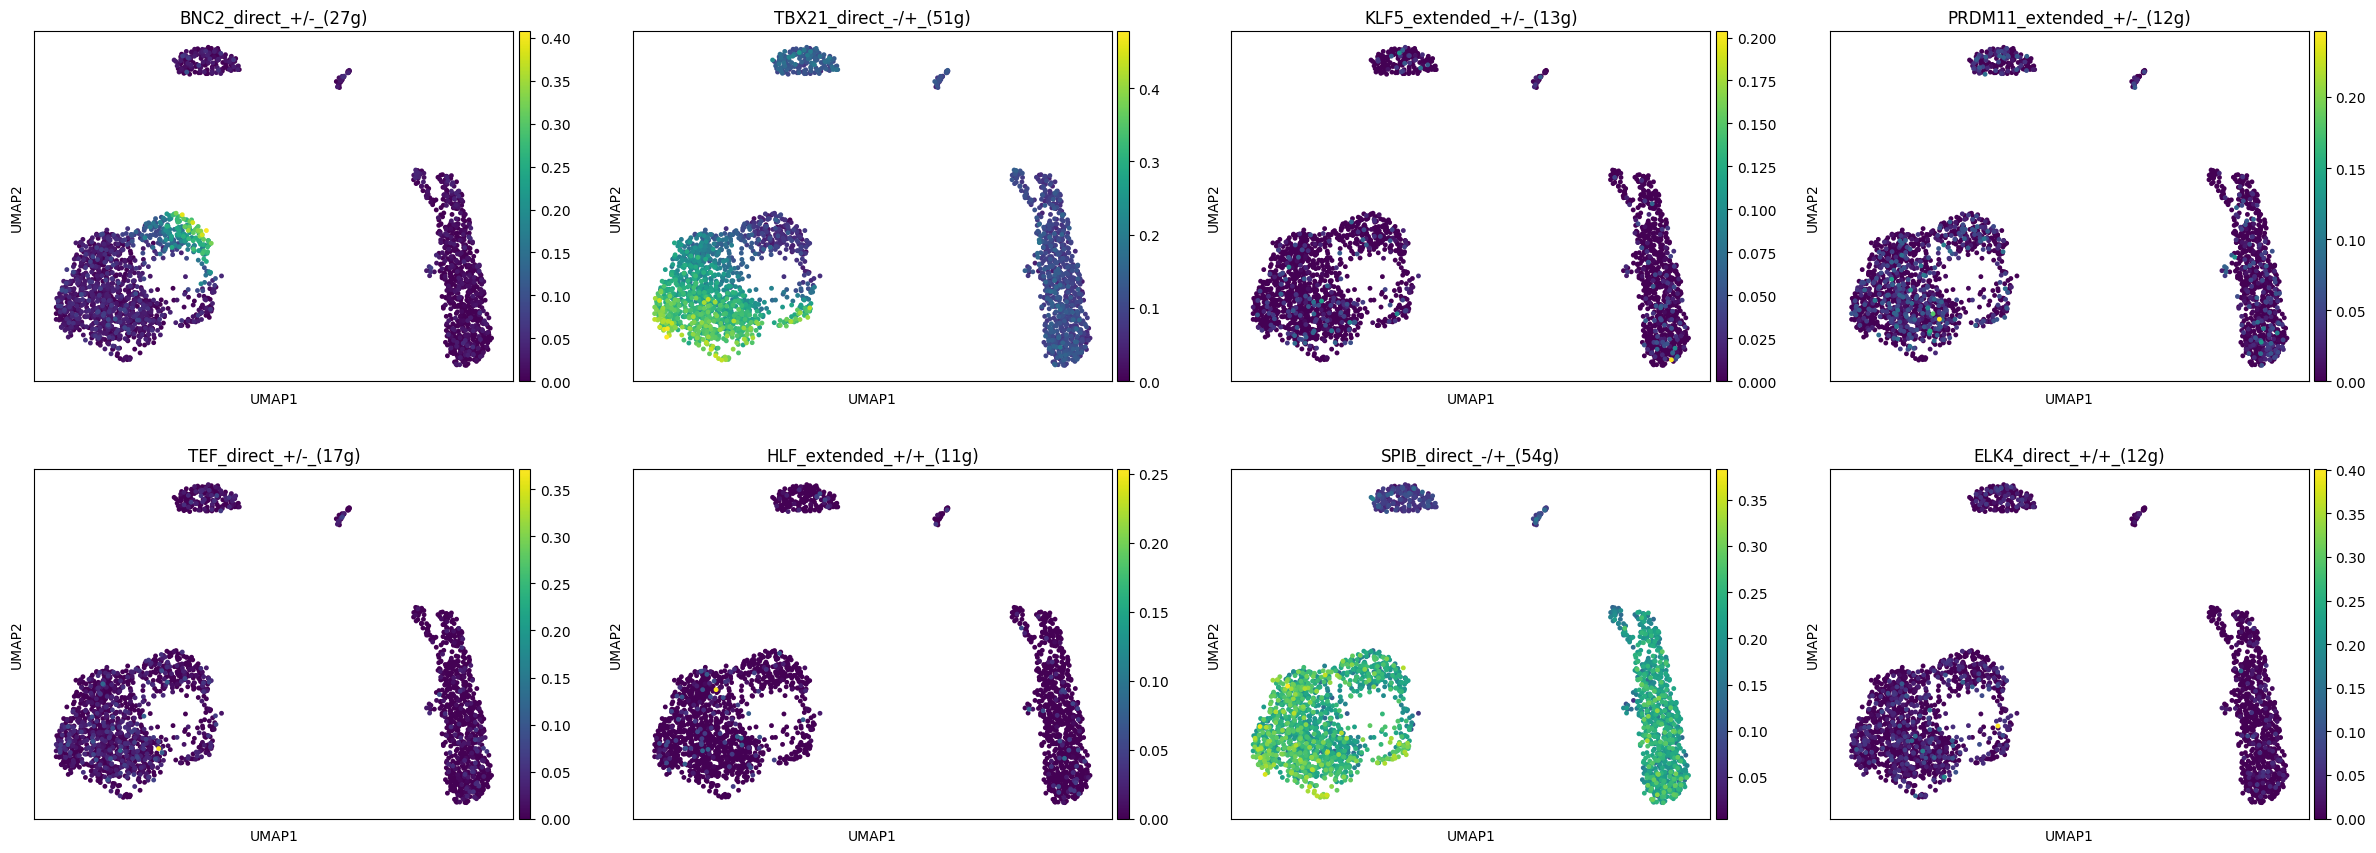

In [46]:
from scenicplus.RSS import *
sc.pl.umap(eRegulon_gene_AUC, color = list(set([x for xs in [rss.loc[ct].sort_values()[0:2].index for ct in rss.index] for x in xs ])))

In [47]:
# import pandas as pd
# from plotnine import (
#     ggplot, geom_point, aes, scale_fill_distiller, 
#     geom_tile, theme, element_text, element_blank)
# from plotnine.facets import facet_grid
# import plotnine
# from typing import List, Union, Optional, Tuple
# from mudata import MuData

# def _scale(X: pd.DataFrame) -> pd.DataFrame:
#     return (X - X.min()) / (X.max() - X.min())

# def generate_dotplot_df(
#     size_matrix: pd.DataFrame,
#     color_matrix: pd.DataFrame,
#     group_by: List[str],
#     size_features: List[str], # size_features, color_features and feature_names the order should correspond, e.g. color_features, size_features, feature_names = scplus_mudata.uns["direct_e_regulon_metadata"][["Region_signature_name", "Gene_signature_name", "eRegulon_name"]].drop_duplicates().values.T
#     color_features: List[str],
#     feature_names: List[str],
#     scale_size_matrix: bool = True,
#     scale_color_matrix: bool = True,
#     group_name: str = "group",
#     size_name: str = "size_variable",
#     color_name: str = "color_variable",
#     feature_name: str = "eRegulon") -> pd.DataFrame:
#     # Validate input
#     if not all(size_matrix.index == color_matrix.index):
#         raise ValueError("Both size_matrix and color_matrix should have the same index")
#     if len(group_by) != len(size_matrix.index):
#         raise ValueError("Length of group_by does not match with the index")
#     if len(size_features) != len(color_features) != len(feature_names):
#         raise ValueError("The length of 'size_features', 'color_features' and 'feature_names' should be equal!")
#     # Subset and order for features
#     size_matrix = size_matrix[size_features]
#     color_matrix = color_matrix[color_features]
#     # Calculate mean by group_by variable
#     color_matrix_avg = color_matrix.groupby(group_by).mean()
#     size_matrix_avg = size_matrix.groupby(group_by).mean()
#     # Scale matrices
#     color_matrix_avg = _scale(color_matrix_avg) if scale_color_matrix else color_matrix_avg
#     size_matrix_avg = _scale(size_matrix_avg) if scale_size_matrix else size_matrix_avg
#     # Transform dataframe into long format
#     color_matrix_avg = color_matrix_avg.stack().reset_index()
#     size_matrix_avg = size_matrix_avg.stack().reset_index()
#     color_matrix_avg.columns = [group_name, "color_features", color_name]
#     size_matrix_avg.columns = [group_name, "size_features", size_name]
#     # map between color and size feature names to feature names
#     color_features_to_name = dict(zip(color_features, feature_names))
#     size_features_to_name = dict(zip(size_features, feature_names))
#     # Add feature names to dataframe
#     color_matrix_avg[feature_name] = [
#         color_features_to_name[f] for f in color_matrix_avg["color_features"]]
#     size_matrix_avg[feature_name] = [
#         size_features_to_name[f] for f in size_matrix_avg["size_features"]]
#     color_matrix_avg = color_matrix_avg.drop("color_features", axis = 1)
#     size_matrix_avg = size_matrix_avg.drop("size_features", axis = 1)
#     dotplot_df = color_matrix_avg.merge(
#         size_matrix_avg,
#         on = [group_name, feature_name])
#     return dotplot_df

# def heatmap_dotplot(
#     scplus_mudata: Union[MuData, ScenicPlusMuData],
#     size_modality: str,
#     color_modality: str,
#     group_variable: str,
#     eRegulon_metadata_key: str,
#     size_feature_key: str,
#     color_feature_key: str,
#     feature_name_key: str,
#     sort_data_by: str,
#     subset_feature_names: Optional[List[str]] = None,
#     scale_size_matrix: bool = True,
#     scale_color_matrix: bool = True,
#     group_variable_order: Optional[List[str]] = None,
#     save: Optional[str] = None,
#     figsize: Tuple[float, float] = (5, 8),
#     split_repressor_activator: bool = True,
#     orientation: str = 'vertical'):
#     # Generate dataframe for plotting
#     size_matrix = scplus_mudata[size_modality].to_df()
#     color_matrix = scplus_mudata[color_modality].to_df()
#     group_by = scplus_mudata.obs[group_variable].tolist()
#     if subset_feature_names is None:
#         size_features, color_features, feature_names = scplus_mudata.uns[eRegulon_metadata_key][
#             [size_feature_key, color_feature_key, feature_name_key]] \
#             .drop_duplicates().values.T
#     else:
#         size_features, color_features, feature_names = scplus_mudata.uns[eRegulon_metadata_key][
#             [size_feature_key, color_feature_key, feature_name_key]] \
#             .drop_duplicates().query(f"{feature_name_key} in @subset_feature_names").values.T
#     plotting_df = generate_dotplot_df(
#         size_matrix=size_matrix,
#         color_matrix=color_matrix,
#         group_by=group_by,
#         size_features=size_features,
#         color_features=color_features,
#         feature_names=feature_names,
#         scale_size_matrix=scale_size_matrix,    
#         scale_color_matrix=scale_color_matrix,
#         group_name=group_variable,
#         size_name=size_modality,
#         color_name=color_modality,
#         feature_name=feature_name_key)
#     # Order data
#     if group_variable_order is not None:
#         if len(set(group_variable_order) & set(plotting_df[group_variable])) != len(set(plotting_df[group_variable])):
#             Warning('not all indices are provided in index_order, order will not be changed!')
#         else:
#             plotting_df[group_variable] = pd.Categorical(plotting_df[group_variable], categories=group_variable_order)
#     tmp = plotting_df[[group_variable, feature_name_key, sort_data_by]] \
#             .pivot_table(index=group_variable, columns=feature_name_key) \
#             .fillna(0)[sort_data_by]
#     if group_variable_order is not None:
#         tmp = tmp.loc[group_variable_order]
#     idx_max = tmp.idxmax(axis = 0)
#     order = pd.concat([idx_max[idx_max == x] for x in tmp.index.tolist() if len(plotting_df[plotting_df == x]) > 0]).index.tolist()
#     plotting_df[feature_name_key] = pd.Categorical(plotting_df[feature_name_key], categories=order)
#     # Plotting
#     plotnine.options.figure_size = figsize
#     plotting_df["repressor_activator"] = [
#             "activator" if "+" in n.split("_")[2] else "repressor" for n in plotting_df[feature_name_key]]
#     if split_repressor_activator and len(set(plotting_df["repressor_activator"])) == 2:
#         if orientation == 'vertical':
#             plot = (
#                 ggplot(plotting_df, aes(group_variable, feature_name_key))
#                 + facet_grid(
#                     'repressor_activator ~ .', 
#                     scales = "free", 
#                     space = {'x': [1], 'y': [sum(plotting_df['repressor_activator'] == 'activator'), sum(plotting_df['repressor_activator'] == 'repressor')]})
#                 + geom_tile(mapping = aes(fill = color_modality))
#                 + scale_fill_distiller(type = 'div', palette = 'RdYlBu')
#                 + geom_point(
#                         mapping = aes(size = size_modality),
#                         colour = "black")
#                 + theme(axis_text_x=element_text(rotation=90, hjust=1))
#                 + theme(axis_title_x = element_blank(), axis_title_y = element_blank()))
#         elif orientation == 'horizontal':
#             plot = (
#                 ggplot(plotting_df, aes(feature_name_key, group_variable))
#                 + facet_grid(
#                     '. ~ repressor_activator', 
#                     scales = "free", 
#                     space = {'y': [1], 'x': [sum(plotting_df['repressor_activator'] == 'activator'), sum(plotting_df['repressor_activator'] == 'repressor')]})
#                 + geom_tile(mapping = aes(fill = color_modality))
#                 + scale_fill_distiller(type = 'div', palette = 'RdYlBu')
#                 + geom_point(
#                         mapping = aes(size = size_modality),
#                         colour = "black")
#                 + theme(axis_text_x=element_text(rotation=90, hjust=1))
#                 + theme(axis_title_x = element_blank(), axis_title_y = element_blank()))
#     else:
#         if orientation == 'vertical':
#             plot = (
#                 ggplot(plotting_df, aes(group_variable, feature_name_key))
#                 + geom_tile(mapping = aes(fill = color_modality))
#                 + scale_fill_distiller(type = 'div', palette = 'RdYlBu')
#                 + geom_point(
#                         mapping = aes(size = size_modality),
#                         colour = "black")
#                 + theme(axis_title_x = element_blank(), axis_title_y = element_blank()))
#         elif orientation == 'horizontal':
#             plot = (
#                 ggplot(plotting_df, aes(feature_name_key, group_variable))
#                 + geom_tile(mapping = aes(fill = color_modality))
#                 + scale_fill_distiller(type = 'div', palette = 'RdYlBu')
#                 + geom_point(
#                         mapping = aes(size = size_modality),
#                         colour = "black")
#                 + theme(axis_title_x = element_blank(), axis_title_y = element_blank()))
#     if save is not None:
#         plot.save(save)
#     else:
#         return plot

## Heatmap dotplot

We can draw a heatmap where the color represent target gene enrichment and the dotsize target region enrichment.

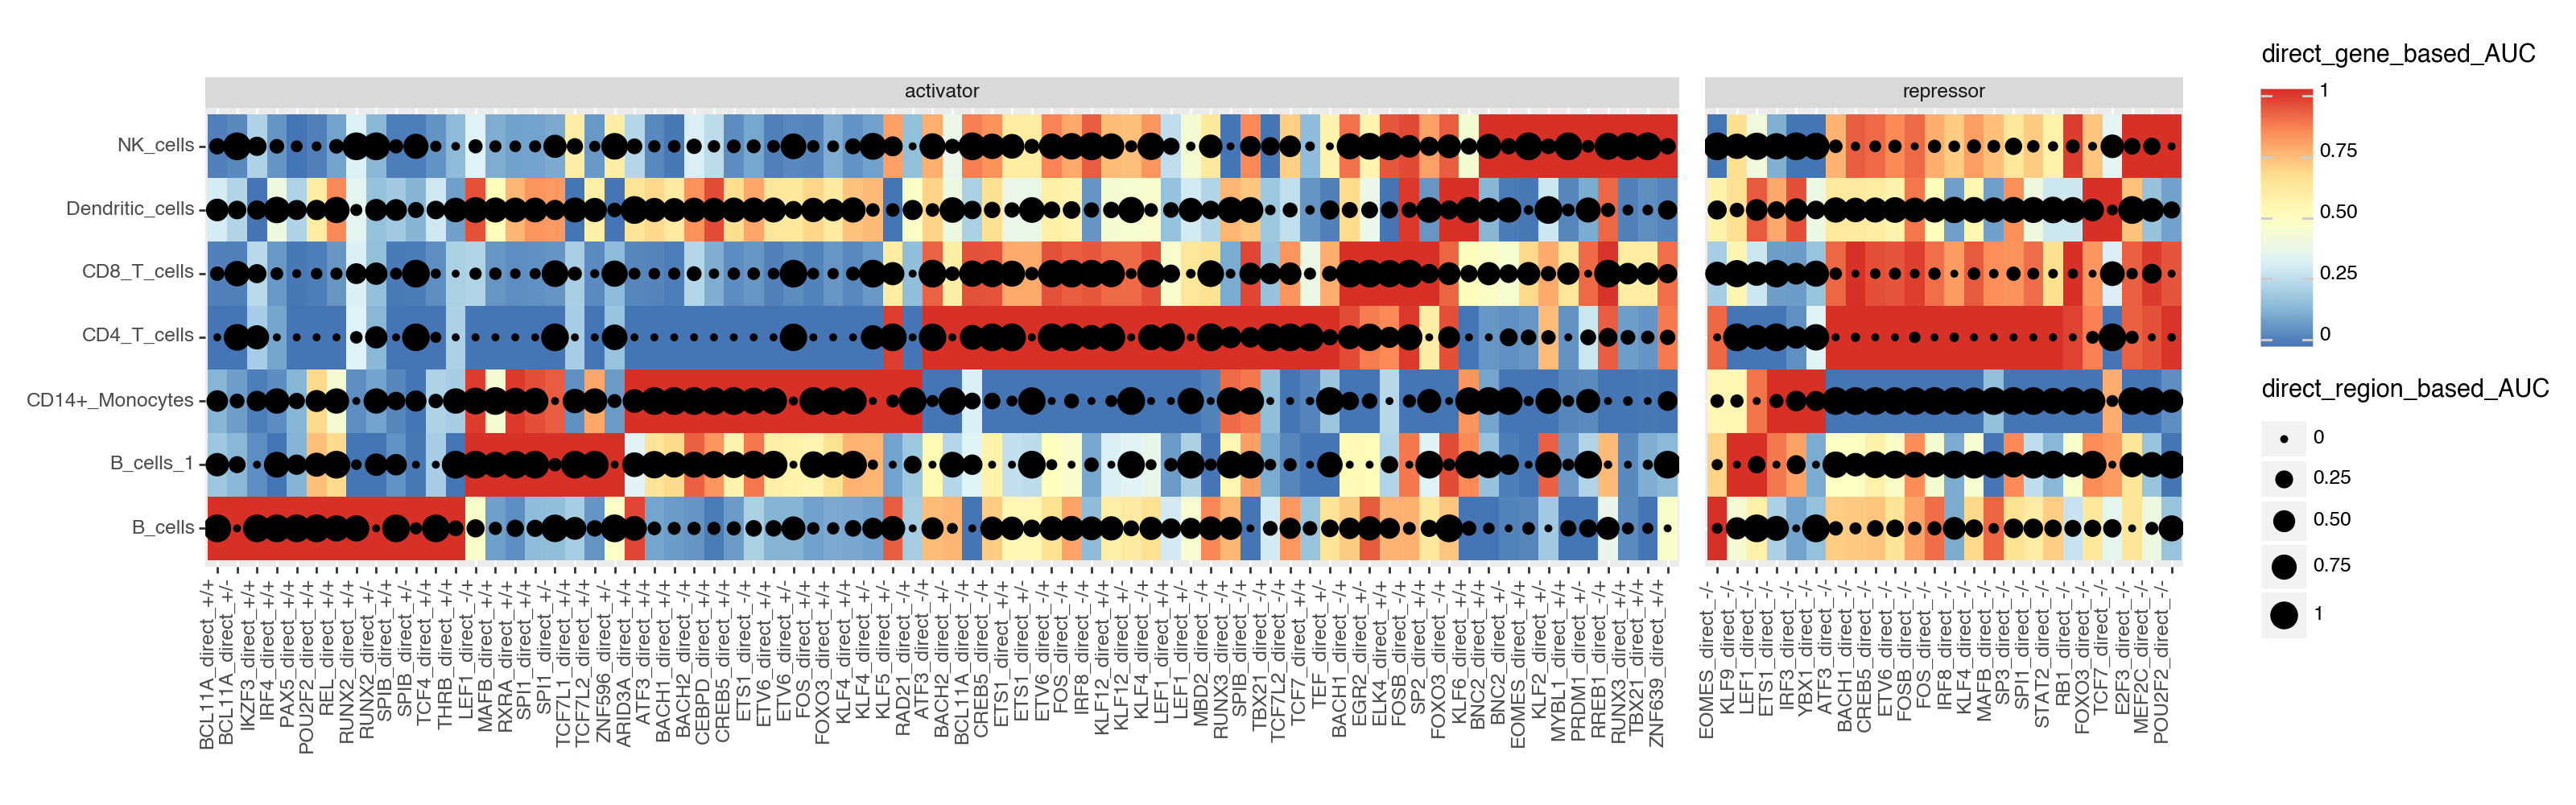

<Figure Size: (1600 x 500)>

In [48]:
heatmap_dotplot(
    scplus_mudata = scplus_mdata,
    color_modality = "direct_gene_based_AUC",
    size_modality = "direct_region_based_AUC",
    group_variable = "scRNA_counts:celltype",
    eRegulon_metadata_key = "direct_e_regulon_metadata",
    color_feature_key = "Gene_signature_name",
    size_feature_key = "Region_signature_name",
    feature_name_key = "eRegulon_name",
    sort_data_by = "direct_gene_based_AUC",
    orientation = "horizontal",
    figsize = (16, 5)
)

In [49]:
scplus_mdata
scplus_mdata.write('/Users/parham/Desktop/scplus_mdata.h5mu')

In [52]:
scenicplus = scplus_mdata['direct_gene_based_AUC'].to_df()
scenicplus

,ARID3A_direct_+/+_(47g),ATF3_direct_+/+_(734g),ATF3_direct_-/+_(174g),ATF3_direct_-/-_(197g),BACH1_direct_+/+_(812g),BACH1_direct_-/+_(94g),BACH1_direct_-/-_(288g),BACH2_direct_+/-_(233g),BACH2_direct_-/+_(742g),BCL11A_direct_+/+_(399g),...,TCF7L1_direct_+/+_(31g),TCF7L2_direct_+/+_(691g),TCF7L2_direct_-/+_(92g),TCF7_direct_+/+_(86g),TCF7_direct_-/-_(13g),TEF_direct_+/-_(17g),THRB_direct_+/+_(30g),YBX1_direct_-/-_(14g),ZNF596_direct_+/-_(15g),ZNF639_direct_+/+_(28g)
Cell,,,,,,,,,,,,,,,,,,,,,
GCCAGGTTCCAAACAC-1-10x_pbmc,0.028742,0.232049,0.075259,0.060498,0.217333,0.036238,0.046436,0.074233,0.171718,0.033529,...,0.000000,0.139868,0.066884,0.057243,0.203777,0.000000,0.000000,0.055100,0.041957,0.000000
TGATTAGTCGGGACTC-1-10x_pbmc,0.012470,0.043575,0.453704,0.381938,0.044167,0.353226,0.260988,0.194449,0.073059,0.036863,...,0.000000,0.039158,0.194446,0.132983,0.142774,0.000000,0.000000,0.063903,0.000000,0.018008
TAGTAACGTGTGTGGT-1-10x_pbmc,0.017434,0.050627,0.502579,0.408914,0.046960,0.360881,0.269592,0.226866,0.073614,0.011826,...,0.016235,0.037093,0.211369,0.220536,0.068239,0.024404,0.013108,0.145814,0.020633,0.027987
AGAGATTAGTCATGCG-1-10x_pbmc,0.019555,0.197549,0.143705,0.119650,0.172424,0.100348,0.089771,0.087008,0.171550,0.037830,...,0.000000,0.137719,0.074788,0.081680,0.239308,0.000000,0.008937,0.002150,0.000000,0.000000
CTTCAATTCAGCATTA-1-10x_pbmc,0.007346,0.193208,0.185968,0.165474,0.175142,0.141460,0.111823,0.110550,0.150748,0.057437,...,0.000000,0.150739,0.056332,0.065501,0.216875,0.000000,0.000000,0.055772,0.070430,0.022544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTAGGCCCACTTACAG-1-10x_pbmc,0.029403,0.034456,0.470497,0.397883,0.042389,0.338604,0.262458,0.261803,0.043742,0.024957,...,0.000000,0.028988,0.216164,0.304776,0.062161,0.000000,0.000000,0.167249,0.000000,0.011087
GTATTGATCCCGAAGC-1-10x_pbmc,0.004884,0.044594,0.414026,0.354776,0.036402,0.327976,0.247093,0.180694,0.074746,0.020955,...,0.000000,0.039670,0.175927,0.131779,0.064332,0.034475,0.024240,0.000000,0.000000,0.000000
ATCAGGTTCCCTGTTA-1-10x_pbmc,0.014531,0.146173,0.361782,0.293103,0.140729,0.278057,0.190917,0.142778,0.177934,0.052929,...,0.000000,0.170685,0.065739,0.030618,0.345756,0.000000,0.006742,0.040788,0.026968,0.007526


In [53]:
cell_names = scplus_mdata.obs['scRNA_counts:celltype'].tolist()
scenicplus.index=cell_names

In [54]:
scenicplus.columns = [col.split('_')[0] for col in scenicplus.columns]
scenicplus.to_csv('/Users/parham/Downloads/scenicplus_cell_tf.csv')
scenicplus

,ARID3A,ATF3,ATF3,ATF3,BACH1,BACH1,BACH1,BACH2,BACH2,BCL11A,...,TCF7L1,TCF7L2,TCF7L2,TCF7,TCF7,TEF,THRB,YBX1,ZNF596,ZNF639
CD14+_Monocytes,0.028742,0.232049,0.075259,0.060498,0.217333,0.036238,0.046436,0.074233,0.171718,0.033529,...,0.000000,0.139868,0.066884,0.057243,0.203777,0.000000,0.000000,0.055100,0.041957,0.000000
CD8_T_cells,0.012470,0.043575,0.453704,0.381938,0.044167,0.353226,0.260988,0.194449,0.073059,0.036863,...,0.000000,0.039158,0.194446,0.132983,0.142774,0.000000,0.000000,0.063903,0.000000,0.018008
CD4_T_cells,0.017434,0.050627,0.502579,0.408914,0.046960,0.360881,0.269592,0.226866,0.073614,0.011826,...,0.016235,0.037093,0.211369,0.220536,0.068239,0.024404,0.013108,0.145814,0.020633,0.027987
CD14+_Monocytes,0.019555,0.197549,0.143705,0.119650,0.172424,0.100348,0.089771,0.087008,0.171550,0.037830,...,0.000000,0.137719,0.074788,0.081680,0.239308,0.000000,0.008937,0.002150,0.000000,0.000000
CD14+_Monocytes,0.007346,0.193208,0.185968,0.165474,0.175142,0.141460,0.111823,0.110550,0.150748,0.057437,...,0.000000,0.150739,0.056332,0.065501,0.216875,0.000000,0.000000,0.055772,0.070430,0.022544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CD4_T_cells,0.029403,0.034456,0.470497,0.397883,0.042389,0.338604,0.262458,0.261803,0.043742,0.024957,...,0.000000,0.028988,0.216164,0.304776,0.062161,0.000000,0.000000,0.167249,0.000000,0.011087
CD8_T_cells,0.004884,0.044594,0.414026,0.354776,0.036402,0.327976,0.247093,0.180694,0.074746,0.020955,...,0.000000,0.039670,0.175927,0.131779,0.064332,0.034475,0.024240,0.000000,0.000000,0.000000
B_cells_1,0.014531,0.146173,0.361782,0.293103,0.140729,0.278057,0.190917,0.142778,0.177934,0.052929,...,0.000000,0.170685,0.065739,0.030618,0.345756,0.000000,0.006742,0.040788,0.026968,0.007526
CD14+_Monocytes,0.000000,0.217075,0.028822,0.019880,0.191259,0.040472,0.029522,0.029728,0.178841,0.047595,...,0.174461,0.153857,0.017046,0.026362,0.276431,0.000000,0.000000,0.211799,0.033239,0.000000
